In [1]:
%pylab inline
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS as linear
import time

Populating the interactive namespace from numpy and matplotlib


In [2]:
path = 'C:/Users/mohdh/Documents/GitHub/yahoo-tumblr'  # <YOUR PATH>
fn = '/Spreadsheet Supplement.csv'  # <YOUR FILENAME>

__FUNctions__

In [3]:
####
# Input: text chunk extracted from file
#
# Output: List of tuples containing values of records
#
# Where used: read_file() function
####
def row_split(cont):
    measurements = None
    try:
        rows = cont.split('\n')
        rows = rows[:-1]
        measurements = [tuple(x.split(',')) for x in rows]
        return measurements
    except:
        print("Check that file contents are gucci!")
        
def read_file(path, filename):
    try:
        with open(path + filename, 'r') as f:
            cont = f.read()

        list_of_tuples = row_split(cont)

        return pd.DataFrame(list_of_tuples[1:], columns = list_of_tuples[0])
    except:
        print('Error encountered when reading in file.')

__Inital data load__

In [4]:
df = read_file(path, fn)
df = df.rename(columns = {'ï»¿People Worldwide' : 'People Worldwide'})

CAGR = (End / Start) ^ (1 / t)

In [7]:
y1 = df['People US'].astype('int')

In [8]:
res = (y1.tolist()[-1] / y1.tolist()[0]) ** (1/len(y1))

In [9]:
temp_res = [y1.tolist()[-1]]
fac = res

for i in range(115):
    if i % 6 == 0:
        fac = fac * 0.99
    temp_res.append(temp_res[-1] * fac)

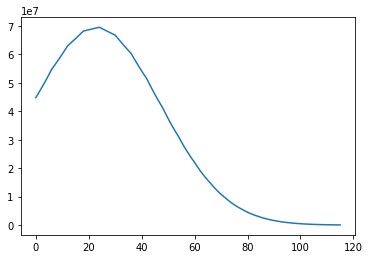

In [10]:
plt.plot(temp_res)
plt.show()

__Log growth approach__

In [11]:
wood = (log(y1.tolist()[-1]) - log(y1.tolist()[0])) / len(y1)

In [12]:
temp_res = [log(y1.tolist()[-1])]
fac = wood

for i in range(115):
    temp_res.append(temp_res[-1] + wood)

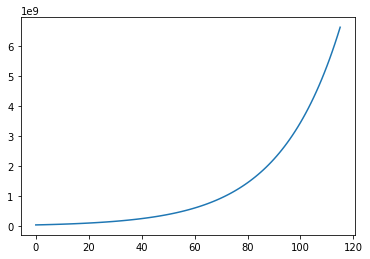

In [13]:
chop = [exp(x) for x in temp_res]

plt.plot(chop)
plt.show()

If we assume Tumblr will keep growing its global user base at the average 38-month growth rate, the site will have 53 billion active users.<br>

This obviously makes no sense, given that there are only 7 billion people in the world, and roughly 1/3 of that are children below 18 y.o. age.

__Using last 12-months to estimate future growth__

__Data exploration__

For the 2 graphs below, global users are in blue and US users are in orange:

Absolute user growth over time

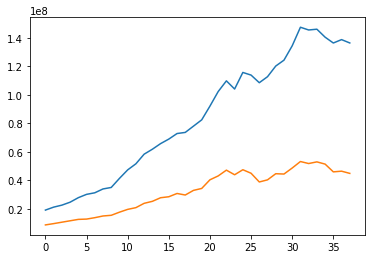

In [14]:
X = np.array(df.index).tolist()
y1 = df['People Worldwide'].astype('int')
y2 = df['People US'].astype('int')

plt.plot(X, y1, y2)
plt.show()

It looks like US user growth is flatlining in later years. We might have to apply a log transformation to validate if that's true.

Logarithmic user growth over time

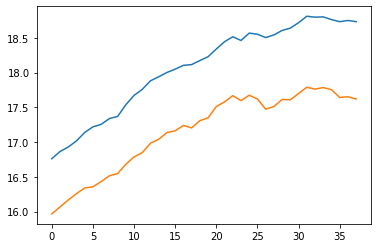

In [15]:
X_log = np.array(df.index).tolist()
y1_log = log(df['People Worldwide'].astype('int'))
y2_log = log(df['People US'].astype('int'))

plt.plot(X_log, y1_log, y2_log)
plt.show()

After applying a log-transform, it looks like US users are growing at the same rate as the rest of the world.

__Introducing lagged variables__

Below is a nifty function to create lag variables very quickly:

In [22]:
def lag_variables(series, n, prefix = ''):
    ####
    # Input: series, n = number of lags
    # 
    # Output: list of tuples containing lag variables
    #
    # Downstream: to be added into main dataframe component for 
    #             further analysis / manipulation
    ####
    import pandas as pd
    assert n > 0
    try:
        temp_list = []
        col_d = {}
        for i in range(n):
            temp_list.append(tuple(series.shift(i + 1).tolist()))
            key = i
            col_name = 'lag' + str(i+1)
            
            if len(prefix) > 0:
                to_append = str(prefix) + '_'
                col_name = to_append + col_name
            
            if key not in col_d:
                col_d[i] = col_name
                
        df = pd.DataFrame(temp_list).transpose().rename(columns = col_d)
        
        return df
    except:
        print('Something went wrong when lagging variables.')
    

In [23]:
lag_variables(y1,3,prefix='test')

,test_lag1,test_lag2,test_lag3
0,NaN,NaN,NaN
1,19020118.0,NaN,NaN
2,21096692.0,19020118.0,NaN
3,22496896.0,21096692.0,19020118.0
4,24571154.0,22496896.0,21096692.0
5,27744680.0,24571154.0,22496896.0
6,30076088.0,27744680.0,24571154.0
7,31175164.0,30076088.0,27744680.0
8,33880472.0,31175164.0,30076088.0
9,34924704.0,33880472.0,31175164.0
